# Term Structure Inflation Proxy-PCA Analysis

Analyzing the term PCA decompositive of each term structure. 

## Packages

In [5]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [6]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/CommodityInflationFactor/root/src")
from SpreadPCABetaFactor import SpreadPCABetaFactor
from ForwardInflationPCABetaFactor import ForwardInflationPCA

## Inflation Swap and Breakeven Rate Curve

In [8]:
def get_data() -> pd.DataFrame: 

    df_out = (pd.concat([
        SpreadPCABetaFactor().get_breakeven_pca().cumsum().assign(group = "breakeven"), 
        SpreadPCABetaFactor().get_inflation_swap_pca().cumsum().assign(group = "inflation")]))

    return df_out

df_data = get_data()

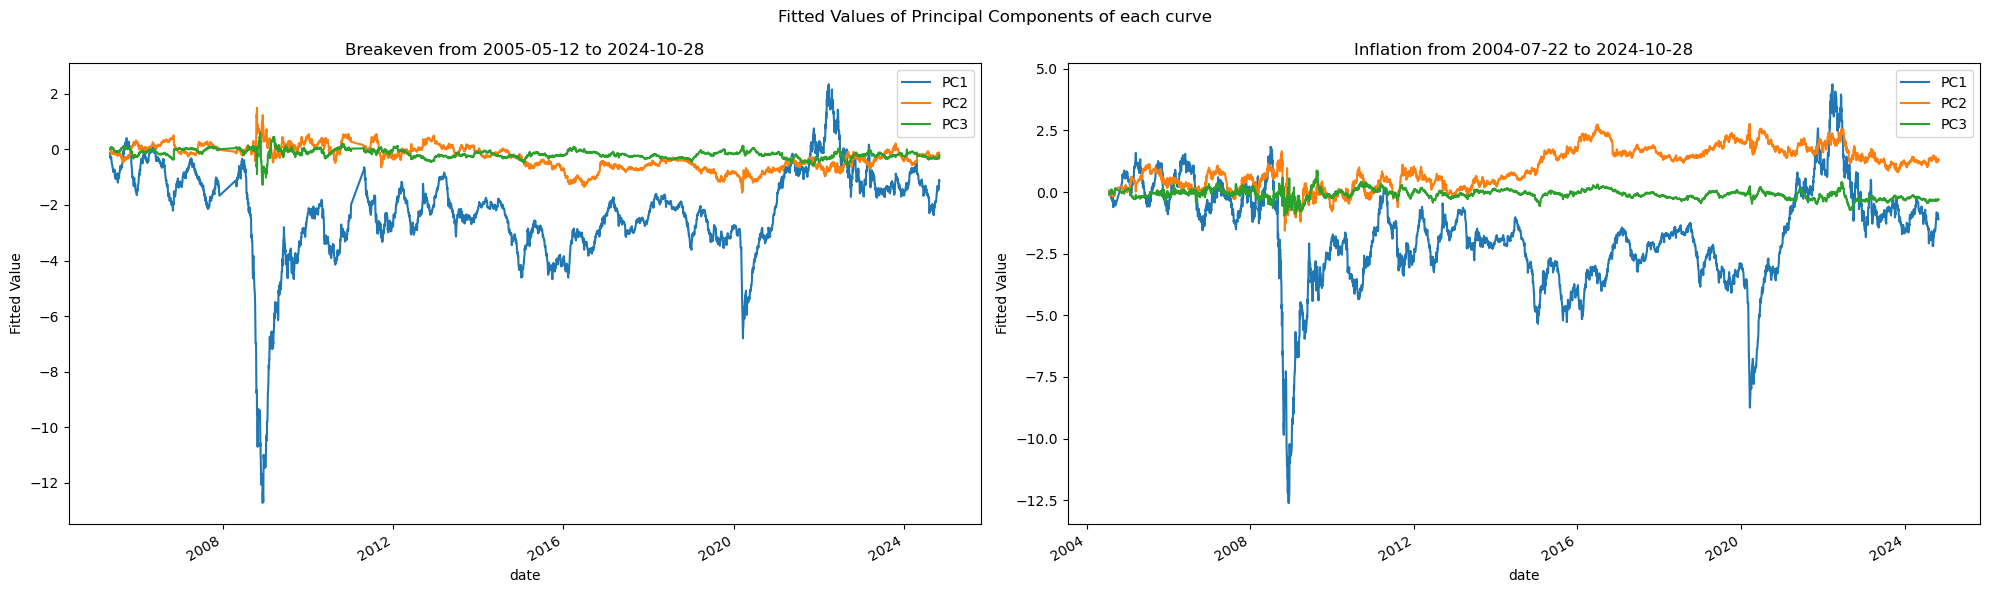

In [9]:
def plot_pca_fitted_values(df_data: pd.DataFrame) -> plt.Figure: 

    groups    = df_data.group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(groups), figsize = (20,6))
    
    for group, ax in zip(groups, axes.flatten()):
    
        df_tmp = (df_data.query(
            "group == @group").
            drop(columns = ["group"]))
        
        (df_tmp.plot(
            ax     = ax,
            ylabel = "Fitted Value",
            title  = "{} from {} to {}".format(
                group.capitalize(),
                df_tmp.index.min().date(),
                df_tmp.index.max().date())))
    
    fig.suptitle("Fitted Values of Principal Components of each curve")
    plt.tight_layout()

plot_pca_fitted_values(df_data)

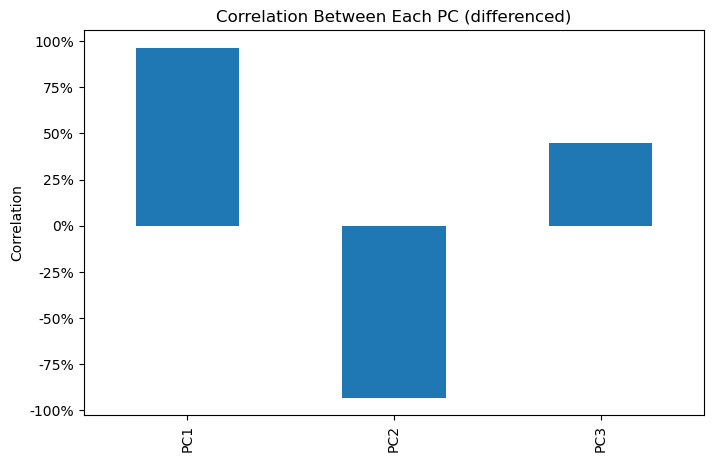

In [10]:
def plot_pca_correlation(df_data: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (8,5))
    
    (df_data.reset_index().melt(
        id_vars = ["date", "group"]).
        pivot(index = ["date", "variable"], columns = "group", values = "value").
        dropna().
        reset_index().
        drop(columns = ["date"]).
        groupby("variable").
        agg("corr").
        reset_index().
        query("breakeven != 1").
        set_index("variable")
        [["breakeven"]].
        plot(
            title  = "Correlation Between Each PC (differenced)",
            kind   = "bar",
            ylabel = "Correlation",
            legend = False,
            xlabel = "",
            ax     = axes))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plot_pca_correlation(df_data)

## 5y5y Forward Inflation

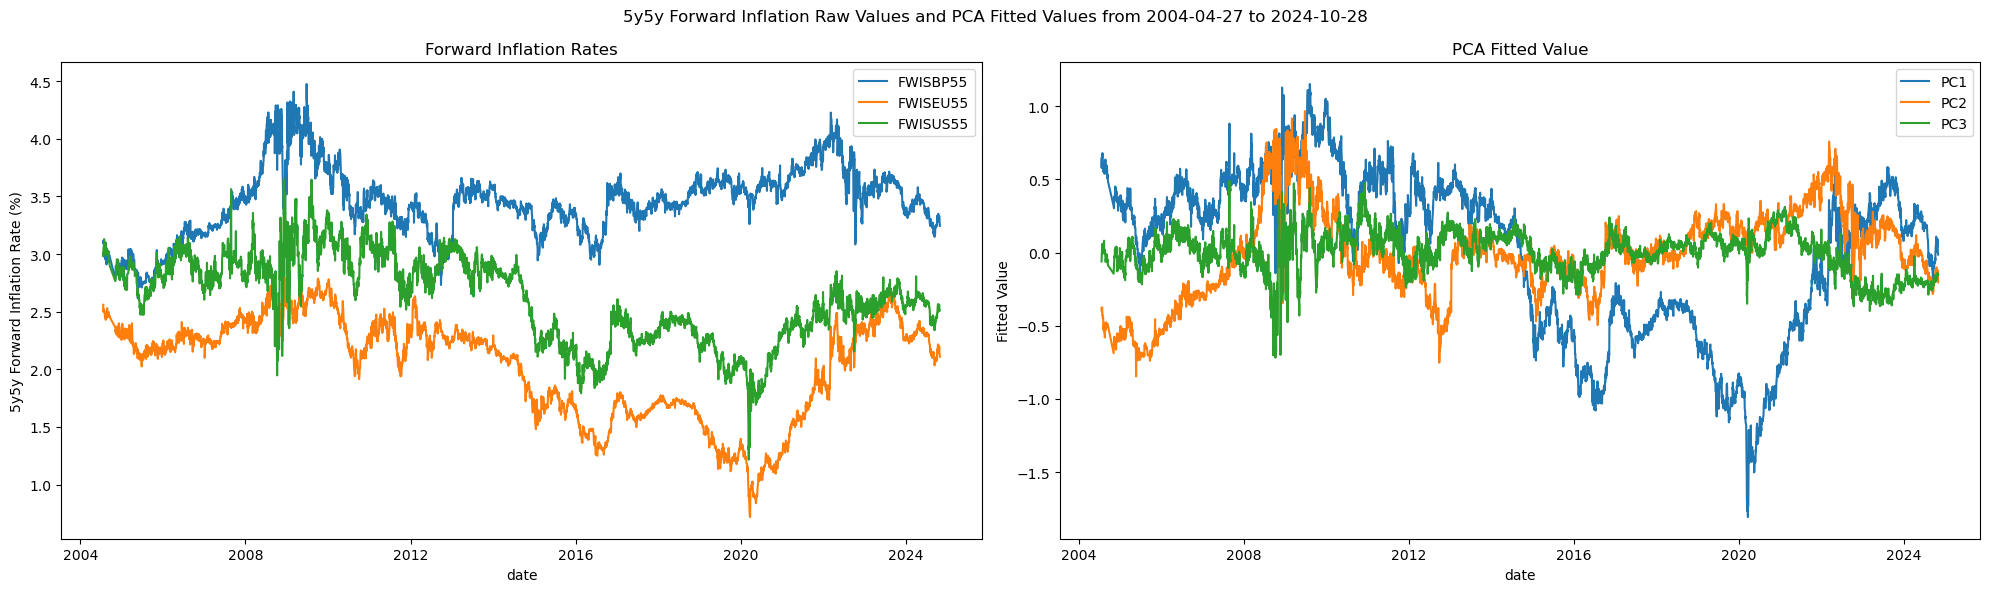

In [12]:
def plot_forward_inflation() -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    
    (SpreadPCABetaFactor().get_five_year_forward_inflation().assign(
        security = lambda x: x.security.str.split(" ").str[0]).
        rename(columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "value").
        dropna().
        plot(
            ylabel = "5y5y Forward Inflation Rate (%)",
            ax     = axes[0],
            title  = "Forward Inflation Rates"))
    
    (ForwardInflationPCA().get_forward_inflation_pca().plot(
        ax     = axes[1],
        ylabel = "Fitted Value",
        title  = "PCA Fitted Value"))
    
    fig.suptitle("5y5y Forward Inflation Raw Values and PCA Fitted Values from {} to {}".format(
        SpreadPCABetaFactor().get_five_year_forward_inflation().date.min(),
        SpreadPCABetaFactor().get_five_year_forward_inflation().date.max()))

    plt.tight_layout()

plot_forward_inflation()